In [1]:
import torch
import torch.nn as nn # neural network modules, CNN layers, ReLU
import torch.optim as optim # optimization algorithms
import torchvision # computer vision
from torchvision.datasets import MNIST # MNIST dataset
import torchvision.transforms as transforms # Image transformations
from torch.utils.data import DataLoader

train_dataset = MNIST(
    root='./data',
    train = True,
    download = True
)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X = train_dataset.data.numpy()

In [4]:
df = pd.DataFrame(X.reshape(len(X), 784))
# len(X) is the number of images in the dataset - becomes rows in DataFrame
# 28 pixels * 28 pixels = 784 - becomes number of columns in dataset

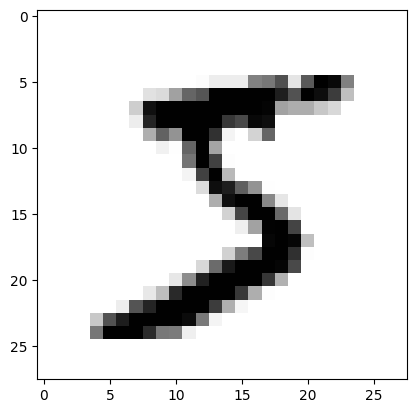

In [5]:
plt.imshow(X[0], cmap='binary')

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), # compresses pixel data to range 0 to 1
    transforms.Normalize((0.1307,), (0.3081)) # Normalizes data
])

train_dataset = MNIST(
    root='./data',
    train = True,
    download = True,
    transform = transform
)

test_dataset = MNIST(
    root = './data',
    train = False,
    download = False,
    transform = transform
)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = False,
    num_workers = 2
)

In [7]:
import torch.nn.functional as F
#contains functions include RelU

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(1600,128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

## Neural Network Architecture
### Conv1
input: 28x28 input image<br>
32 filters -> 32 output channels<br>
3x3 filters<br>
### Cov2
32 channels from conv1<br>
64 filters -> 64 output channels<br>
NOTE each filter is actually 3x3x32 (depth of 32)<br>
### maxPool
Takes max of each 2x2 area:
Original Matrix (6x6):
\begin{bmatrix}
9 & 2 & 6 & 1 & 3 & 4 \\
4 & 3 & 8 & 7 & 2 & 5 \\
1 & 5 & 2 & 3 & 8 & 9 \\
7 & 2 & 4 & 6 & 1 & 3 \\
2 & 3 & 1 & 5 & 4 & 2 \\
8 & 5 & 3 & 2 & 7 & 1
\end{bmatrix}

MaxPool Windows (2x2):

Window 1:
\begin{bmatrix} 
9 & 2 \\ 
4 & 3 
\end{bmatrix} 
<p style="text-align:center;">Max = 9</p>

Window 2:
\begin{bmatrix} 
6 & 1 \\ 
8 & 7 
\end{bmatrix} 
<p style="text-align:center;">Max = 8</p>

Window 3:
\begin{bmatrix} 
3 & 4 \\ 
2 & 5 
\end{bmatrix} 
<p style="text-align:center;">Max = 5</p>

... for all windows

Result (3x3):
\begin{bmatrix}
9 & 8 & 5 \\
7 & 6 & 9 \\
8 & 5 & 7
\end{bmatrix}
### Fully-Connected Layers

Takes an flattened input from the convolutional layers:

$\begin{bmatrix}
a_1 & a_2 & a_3 & a_4 & a_5 & ... & a_{1600}
\end{bmatrix}$
<br>
<br>NOTE this represents one of 32 batches

1. **First Layer** `(1600 → 128)` :
   - **Input**: 1600 features (64 * (5x5)) - flattened conv2 output
   - **Output**: 128 combined patterns (more important patterns)
   - **Purpose**: Combine and reduce features

2. **Second Layer** `(128 → 10)` :
   - **Input**: 128 patterns
   - **Output**: 10 values (one per digit)
   - **Purpose**: Final classification decision

#### Example:

- Conv layers found: edges, curves, lines
- FC layers combine these:
  - "If vertical line + curve -> probably 2"
  - "If two curves -> probably 8"ably 2"
"If two curves -> probably 8"


## Forward Pass
### Key steps:

1. Input: batch of images (batch_size, 1, 28, 28)
2. Conv1 -> ReLU -> MaxPool
3. Conv2 -> ReLU -> MaxPool
4. Flatten for Fully-Connected Layers
5. FC1 -> ReLU
6. FC2
7. Output: digit from 0-9 (batch_size, 10)

In [9]:
model = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda -> NVIDIA's platform for GPU computing
model = model.to(device)
if torch.cuda.is_available():
    print("GPU is available!")
    print("Using:", torch.cuda.get_device_name(0))
else:
    print("No GPU, using CPU instead")

GPU is available!
Using: NVIDIA GeForce RTX 4060 Laptop GPU


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Cross Entropy Loss
- Converts outputs to probabilities
- p = probability of correct output
- Loss = $-\log(p)$
- Better for classification
### Adam Optimizer
- Smart Gradient Descent to update weights
- Adapts learning rates per paremeter
- Uses momentum for faster convergence

In [11]:
def train_model(model, train_loader, test_loader, epochs):

    # Lists to store losses for plotting
    train_losses = []
    test_losses = []
    accuracies = []
    epochs_list = []

    print(f"\n{'='*50}")
    print(f"Starting Training for {epochs} epochs...")
    print(f"{'='*50}")
    
    max_eval_batches = len(test_loader) + 10  # Safety margin
    
    for epoch in range(epochs):
        print(f"\n{'*'*20} EPOCH {epoch+1}/{epochs} {'*'*20}")
        
        # TRAINING PHASE
        print("\nStarting Training Phase...")
        model.train()  # Sets model to training mode
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Moves to GPU

            # Forward pass
            optimizer.zero_grad()  # Clears previous gradients
            output = model(data)   # Gets predictions
            loss = criterion(output, target)  # Calculates loss using CrossEntropyLoss

            # Backpropagation
            loss.backward()  # Calculates gradients

            # Optimization Step
            optimizer.step()  # Updates weights

            # Track Loss
            running_loss += loss.item()
            
            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Training Batch: {batch_idx}/{len(train_loader)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%) '
                      f'Loss: {loss.item():.6f}')
                
        train_losses.append(running_loss / len(train_loader))
                
        # Evaluation Phase
        print("\nStarting Evaluation Phase...")
        model.eval()  # Puts model into evaluation mode
        test_loss = 0  # Accumulates total loss
        correct = 0    # Counts correct predictions
        eval_batch_count = 0  # Track number of evaluation batches

        try:
            with torch.no_grad():  # Disables gradient calculations
                for batch_idx, (data, target) in enumerate(test_loader):
                    # Safety check
                    if batch_idx > max_eval_batches:
                        raise Exception("Evaluation running too many batches! Emergency stop.")
                        
                    print(f'Evaluating batch: {batch_idx}/{len(test_loader)}', end='\r')
                    
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    pred = output.argmax(dim=1, keepdim=True)  # Gets predicted digit (0-9) with highest probability
                    correct += pred.eq(target.view_as(pred)).sum().item()  # Counts correct predictions in batch
                    eval_batch_count += 1

            # Compute final metrics
            test_loss /= len(test_loader)  # Computes average loss
            accuracy = 100. * correct / len(test_loader.dataset)  # Calculates final accuracy

            # Store metrics for plotting
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            epochs_list.append(epoch + 1)

            print(f"\n{'-'*50}")
            print(f'Epoch {epoch+1} Results:')
            print(f'Evaluated {eval_batch_count} batches')
            print(f'Test set: Average loss: {test_loss:.4f}')
            print(f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
            print(f"{'-'*50}")


        except Exception as e:
            print(f"\nEvaluation stopped: {str(e)}")
            print("Current stats:")
            print(f"Processed batches: {eval_batch_count}")
            print(f"Correct predictions: {correct}")
            return  # Exit the function if evaluation goes wrong
        
    # Plot losses after all epoch
    plt.figure(figsize=(20, 5))
    
    # Loss subplot
    plt.subplot(1, 2, 1)
    #plt.plot(epochs_list, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_list, test_losses, label='Test Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*50}")
    print("Training Complete!")
    print(f"{'='*50}")

### Code Explanation
`pred = output.argmax(dim=1, keepdim=True)`
- `.argmax()`: Gets index of highest value
- `dim=1` : Specifies dimensions (1-D row)

`correct += pred.eq(target.view_as(pred)).sum().item()`
- `eq()`: Elemement-weise equality comparison

$$
\begin{bmatrix} 
2 \\
7 \\
4
\end{bmatrix}
$$

<p style="text-align:center;">Predictions</p>
<br>

$$
\begin{bmatrix} 
2 \\
3 \\
4
\end{bmatrix}
$$
<p style="text-align:center;">Targets</p>
<br>

$$
\begin{bmatrix} 
True \\
False \\
True
\end{bmatrix}
$$
<p style="text-align:center;">pred.eq(target)</p>

<br>

- `target.view_as(pred)`: converts numbers to coulumn vector
- `.sum()`: Counts true values and stores into tensor e.g. `Tensor(2)`
- `.item`: Converts tensor to python number


Starting Training for 10 epochs...

******************** EPOCH 1/10 ********************

Starting Training Phase...
Training Batch: 0/1875 (0%) Loss: 2.315629
Training Batch: 100/1875 (5%) Loss: 0.237896
Training Batch: 200/1875 (11%) Loss: 0.121574
Training Batch: 300/1875 (16%) Loss: 0.279906
Training Batch: 400/1875 (21%) Loss: 0.020076
Training Batch: 500/1875 (27%) Loss: 0.035177
Training Batch: 600/1875 (32%) Loss: 0.171019
Training Batch: 700/1875 (37%) Loss: 0.009996
Training Batch: 800/1875 (43%) Loss: 0.026723
Training Batch: 900/1875 (48%) Loss: 0.003401
Training Batch: 1000/1875 (53%) Loss: 0.048501
Training Batch: 1100/1875 (59%) Loss: 0.038606
Training Batch: 1200/1875 (64%) Loss: 0.037373
Training Batch: 1300/1875 (69%) Loss: 0.024865
Training Batch: 1400/1875 (75%) Loss: 0.124261
Training Batch: 1500/1875 (80%) Loss: 0.012509
Training Batch: 1600/1875 (85%) Loss: 0.035664
Training Batch: 1700/1875 (91%) Loss: 0.046255
Training Batch: 1800/1875 (96%) Loss: 0.008158

St

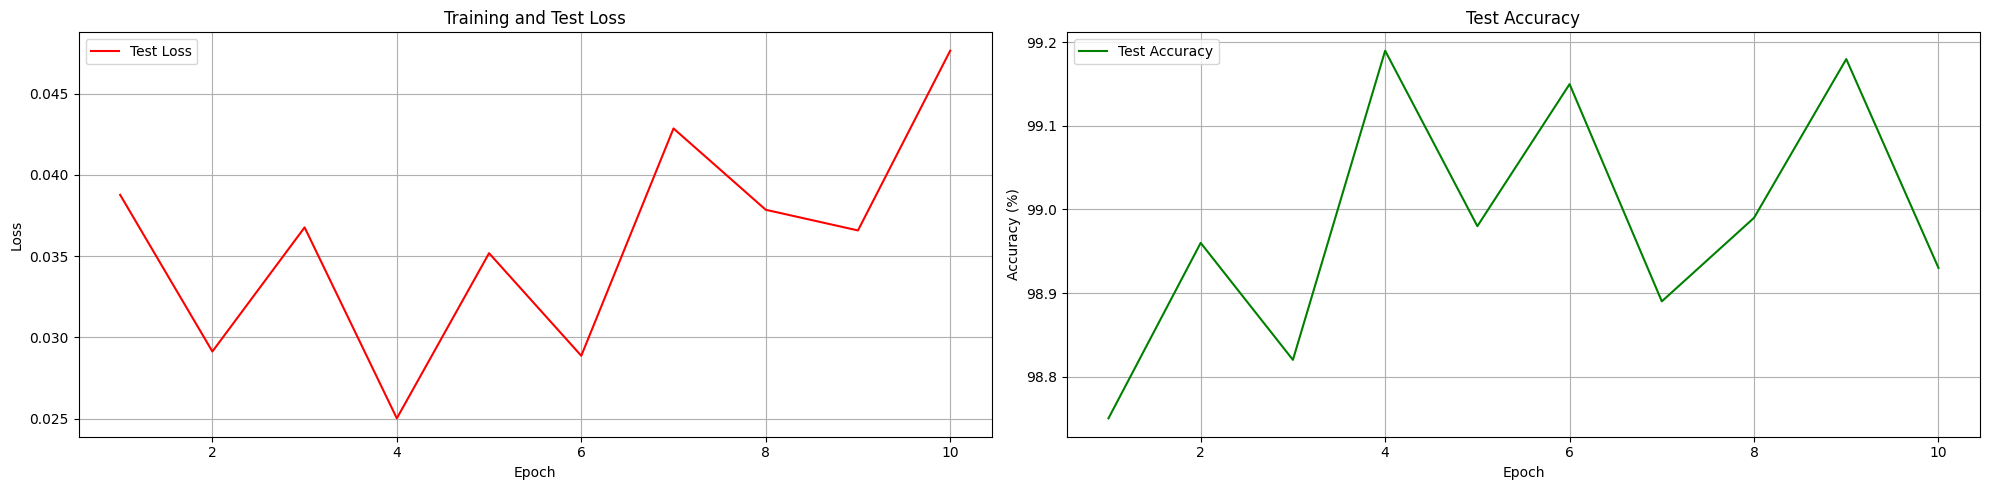


Training Complete!


In [12]:
try:
    train_model(model, train_loader, test_loader, epochs=10)
except KeyboardInterrupt:
    print("\nTraining interrupted by user")